In [2]:
from pybliometrics import scopus
import pandas as pd
import numpy as np
import geopandas
import folium
import mapclassify
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="nmr-map")
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2, country_name_to_country_alpha3
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
def get_continent(col):
    try:
        cn_a2_code =  country_name_to_country_alpha2(col)
        cn_a3_code =  country_name_to_country_alpha3(col)
    except:
        cn_a2_code = 'Unknown' 
        cn_a3_code = 'Unknown' 
    try:
        cn_continent = country_alpha2_to_continent_code(cn_a2_code)
    except:
        cn_continent = 'Unknown' 
    return (cn_a2_code, cn_a3_code, cn_continent)

def geolocate(country):
    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return latitude and longitude
        return (loc.latitude, loc.longitude)
    except:
        # Return missing value
        return (np.nan, np.nan)

In [4]:
query='(KEY(nmr) OR KEY("nuclear magnetic resonance spectroscopy") OR KEY("nuclear magnetic resonance spectrometry"))  AND PUBYEAR IS 2021'
#query='KEY(NMR) AND PUBYEAR IS 2021'
s = scopus.ScopusSearch(query, refresh=False)
#eids = ScopusSearch(query).get_eids()
if s.get_results_size() > 0:
    print(s.get_results_size())

13158


In [5]:
dic={}
i=0
for pub in s.results:
    #print(pub.affiliation_country)
    if pub.affiliation_country:
        countries=list(set(pub.affiliation_country.split(";")))
        #print(countries)
        for country in countries:
            if country == "Cote d'Ivoire":
                country="Ivory Coast"
            if country == "Libyan Arab Jamahiriya":
                country="Libya"
            if dic.get(country):
                dic[country][0]+=1                
            else:
                code2, code3, continent = get_continent(country)
                #lat, lon = geolocate(country)
                dic[country] = [1,code2, code3,  continent]
    i+=1

In [6]:
df = pd.DataFrame.from_dict(dic, orient="index", columns=["affil_count", "code2", "code3", "continent"])
df.rename(index={"Cote d'Ivoire":"Ivory Coast"}, inplace=True)

#df.drop(["affil_count"], axis=1).to_csv("countries_lat_long.csv")

# Koordinaten, falls man Text auf die Länder schreiben will (vorher über geolocate oben geholt, 
# dauert eine Weile)
#coords = pd.read_csv("countries_lat_long.csv", index_col=0)
#df = df.merge(coords, how="left", right_index=True, left_index=True, suffixes=("", "_y"))
#    .drop(["code2_y", "code3_y", "continent_y"], axis=1)

df=df.sort_values(by="affil_count", ascending=False)

df.groupby("continent").sum()
df.to_csv("keyword_nmr_2021.csv") #.drop(["latitude", "longitude"], axis=1)
df.head(20)
#df[df.code2 == "Unknown"]

,affil_count,code2,code3,continent
China,3004,CN,CHN,AS
United States,2430,US,USA,NA
Germany,1330,DE,DEU,EU
United Kingdom,890,GB,GBR,EU
India,876,IN,IND,AS
France,743,FR,FRA,EU
Japan,706,JP,JPN,AS
Italy,701,IT,ITA,EU
Russian Federation,570,RU,RUS,EU
Canada,442,CA,CAN,NA


<Axes: >

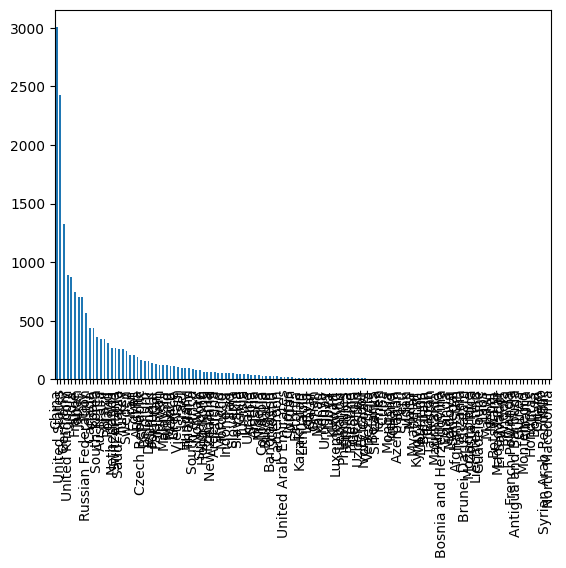

In [7]:
%matplotlib inline
df["affil_count"].plot(kind="bar")

In [8]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
#world = world.to_crs(epsg=3857)
world.head()

/tmp/ipykernel_1257086/2115379554.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [9]:
# worldbank data: https://data.worldbank.org/indicator/SP.POP.TOTL , missing Taiwan and some other countries that are bundled into regions
import tempfile
import urllib.request
import zipfile
from pathlib import Path
_, pop_file = tempfile.mkstemp(suffix=".zip")
urllib.request.urlretrieve("https://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv", pop_file)

pop_dir = tempfile.mkdtemp()
with zipfile.ZipFile(pop_file) as zip_ref:
    zip_ref.extractall(pop_dir)
    
population_file = list(Path(pop_dir).glob("API_SP.POP.TOTL*.csv"))[0]
population = pd.read_csv(population_file, header=2)
population #[population["Indicator Code"] != "SP.POP.TOTL"]

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,Unnamed: 67
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54608.0,55811.0,56682.0,57475.0,58178.0,58782.0,...,103594.0,104257.0,104874.0,105439.0,105962.0,106442.0,106585.0,106537.0,106445.0,NaN
1,Africa Eastern and Southern,AFE,"Population, total",SP.POP.TOTL,130692579.0,134169237.0,137835590.0,141630546.0,145605995.0,149742351.0,...,583651101.0,600008424.0,616377605.0,632746570.0,649757148.0,667242986.0,685112979.0,702977106.0,720839314.0,NaN
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8622466.0,8790140.0,8969047.0,9157465.0,9355514.0,9565147.0,...,32716210.0,33753499.0,34636207.0,35643418.0,36686784.0,37769499.0,38972230.0,40099462.0,41128771.0,NaN
3,Africa Western and Central,AFW,"Population, total",SP.POP.TOTL,97256290.0,99314028.0,101445032.0,103667517.0,105959979.0,108336203.0,...,397855507.0,408690375.0,419778384.0,431138704.0,442646825.0,454306063.0,466189102.0,478185907.0,490330870.0,NaN
4,Angola,AGO,"Population, total",SP.POP.TOTL,5357195.0,5441333.0,5521400.0,5599827.0,5673199.0,5736582.0,...,27128337.0,28127721.0,29154746.0,30208628.0,31273533.0,32353588.0,33428486.0,34503774.0,35588987.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,"Population, total",SP.POP.TOTL,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,...,1812771.0,1788196.0,1777557.0,1791003.0,1797085.0,1788878.0,1790133.0,1786038.0,1761985.0,NaN
262,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,5542459.0,5646668.0,5753386.0,5860197.0,5973803.0,6097298.0,...,27753304.0,28516545.0,29274002.0,30034389.0,30790513.0,31546691.0,32284046.0,32981641.0,33696614.0,NaN
263,South Africa,ZAF,"Population, total",SP.POP.TOTL,16520441.0,16989464.0,17503133.0,18042215.0,18603097.0,19187194.0,...,54729551.0,55876504.0,56422274.0,56641209.0,57339635.0,58087055.0,58801927.0,59392255.0,59893885.0,NaN
264,Zambia,ZMB,"Population, total",SP.POP.TOTL,3119430.0,3219451.0,3323427.0,3431381.0,3542764.0,3658024.0,...,15737793.0,16248230.0,16767761.0,17298054.0,17835893.0,18380477.0,18927715.0,19473125.0,20017675.0,NaN


In [10]:
table = world.merge(df, how="left", left_on=['iso_a3'], right_on='code3', suffixes=("", "_y"))
table["affil_count"]=table["affil_count"].fillna(0)
table["affil_count_per_mio"]=table["affil_count"]/table["pop_est"]*1000000
table[table["name"]=="China"] #.head(5)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,affil_count,code2,code3,continent_y,affil_count_per_mio
139,1.397715e+09,Asia,China,CHN,14342903,"MULTIPOLYGON (((109.47521 18.19770, 108.65521 ...",3004.0,CN,CHN,AS,2.149222


In [11]:
table = (table.merge(population[["Country Code", "2021"]], how="left", left_on='iso_a3', right_on='Country Code', suffixes=("", "_y"))
                 .rename(columns={"2021": "population"}))
table[pd.isna(table["Country Code"])]

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,affil_count,code2,code3,continent_y,affil_count_per_mio,Country Code,population
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",0.0,NaN,NaN,NaN,0.000000,NaN,NaN
20,3398.0,South America,Falkland Is.,FLK,282,"POLYGON ((-61.20000 -51.85000, -60.00000 -51.2...",0.0,NaN,NaN,NaN,0.000000,NaN,NaN
23,140.0,Seven seas (open ocean),Fr. S. Antarctic Lands,ATF,16,"POLYGON ((68.93500 -48.62500, 69.58000 -48.940...",0.0,NaN,NaN,NaN,0.000000,NaN,NaN
140,23568378.0,Asia,Taiwan,TWN,1127000,"POLYGON ((121.77782 24.39427, 121.17563 22.790...",122.0,TW,TWN,AS,5.176427,NaN,NaN
159,4490.0,Antarctica,Antarctica,ATA,898,"MULTIPOLYGON (((-48.66062 -78.04702, -48.15140...",0.0,NaN,NaN,NaN,0.000000,NaN,NaN
160,326000.0,Asia,N. Cyprus,CYN,3600,"POLYGON ((32.73178 35.14003, 32.80247 35.14550...",0.0,NaN,NaN,NaN,0.000000,NaN,NaN
167,5096159.0,Africa,Somaliland,SOL,17836,"POLYGON ((48.94820 11.41062, 48.94820 11.41062...",0.0,NaN,NaN,NaN,0.000000,NaN,NaN
174,1794248.0,Europe,Kosovo,-99,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",0.0,NaN,NaN,NaN,0.000000,NaN,NaN


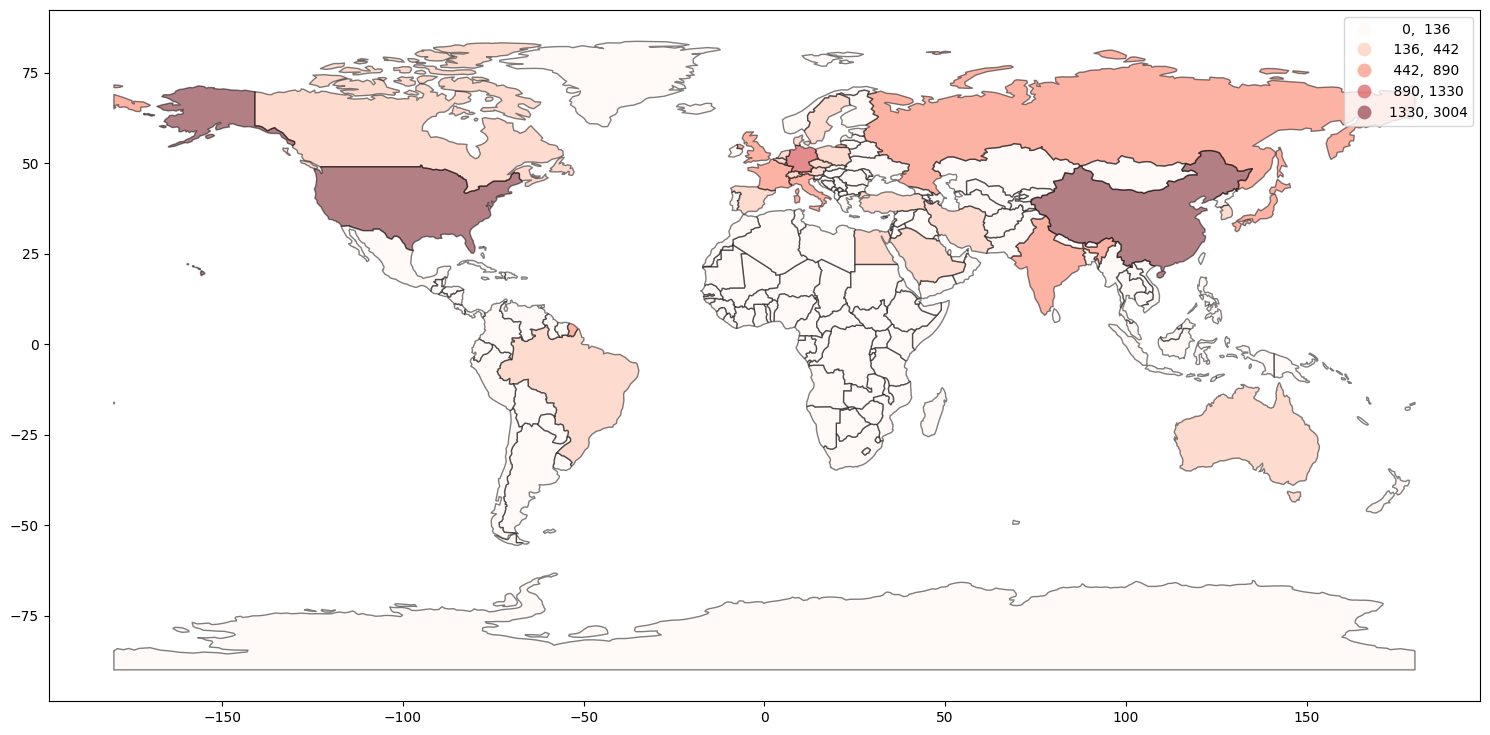

In [12]:
ax = table.plot(column='affil_count',figsize=(15, 8), alpha=0.5, edgecolor='k', cmap='Reds',
                legend=True, scheme="natural_breaks", k=5,
             legend_kwds={'fmt':"{:.0f}"})

plt.tight_layout()
plt.savefig('nmr-affiliations_naturalbreaks.jpg')

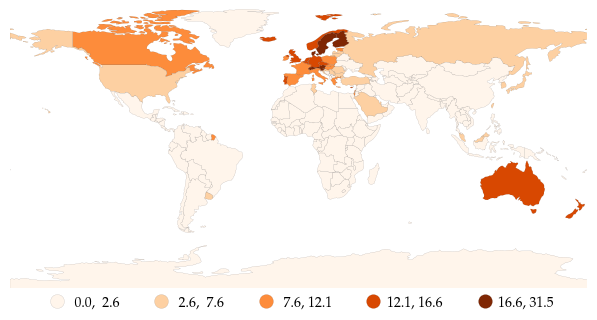

In [13]:
cm = 1 / 2.54
fig, ax = plt.subplots(figsize=(16.0*cm,29.7*cm))  # Wide Layout: ~16cm, Margin Layout: 10.7cm
ax = table.plot(
    ax=ax,
    column="affil_count_per_mio",
    alpha=1,
    edgecolor="k",
    linewidth=0.05,
    cmap="Oranges",
    legend=True,
    scheme="natural_breaks",
    k=5,
    legend_kwds={
        "fmt": "{:.1f}",
        "loc": "upper center",
        "bbox_to_anchor": (0.5, 0.0),
        "ncols": 5,
        "prop": {"family": "TeX Gyre Pagella"},
        "frameon": False,
        "columnspacing": 2, # default: 2
        "handletextpad": 0, # default: 0.8
        "fontsize": 11,
        "borderpad": 0,  # default: 0.4
        "handlelength": 2, # default: 2.0
    },
)

for legend_handle in ax.get_legend().legend_handles:
    legend_handle.set_markeredgecolor("black")
    legend_handle.set_markeredgewidth(0.05)

# Remove axis and whitespace
ax.axis("off")
ax.margins(0,0)

fig.tight_layout()
fig.savefig("nmr-affiliations-per-million-people_naturalbreaks.pdf", bbox_inches="tight", pad_inches=0.0)

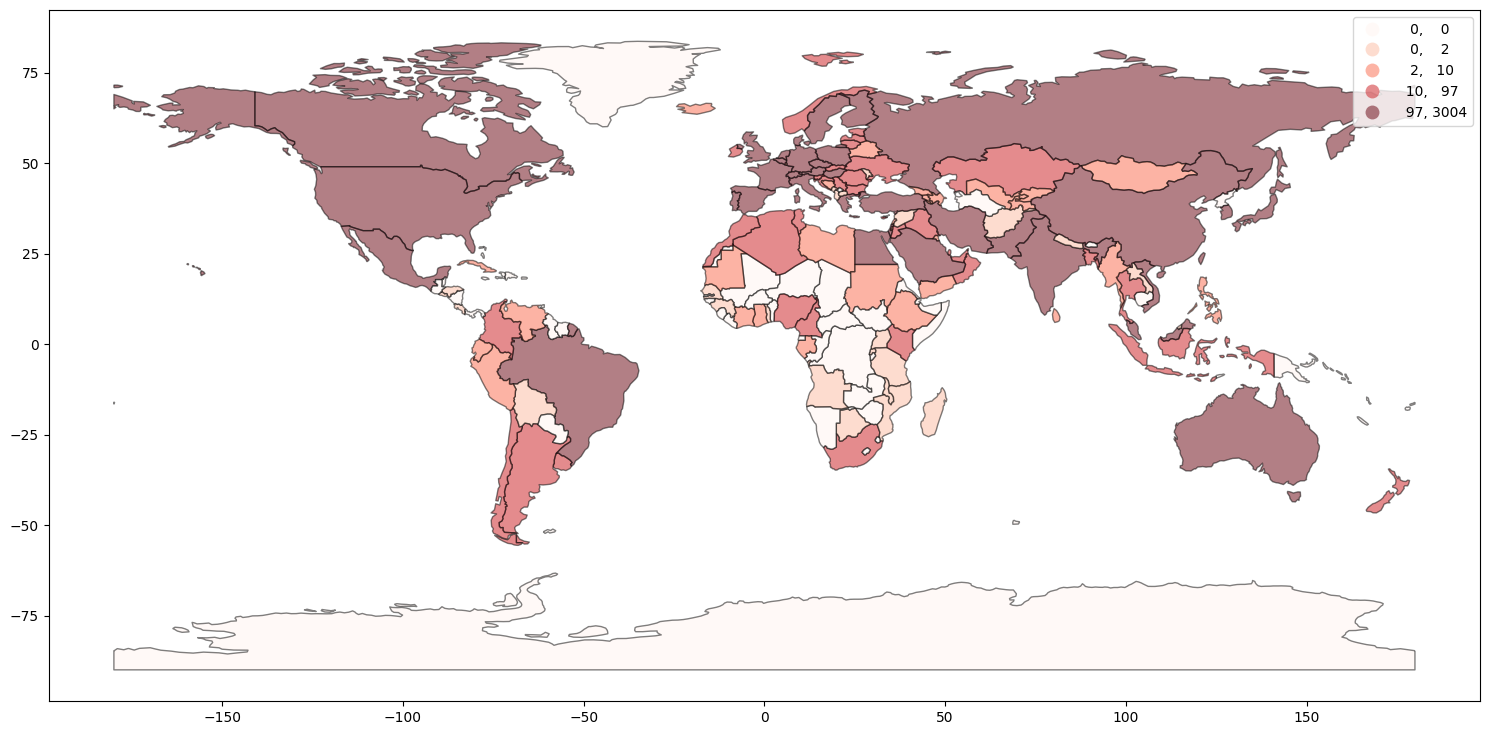

In [14]:
ax = table.plot(column='affil_count',figsize=(15, 8), alpha=0.5, edgecolor='k', cmap='Reds',
                legend=True, scheme="quantiles", k=5,
             legend_kwds={'fmt':"{:.0f}"})

#for idx, row in table.iterrows():
#    if not pd.isna(row.longitude):
#        ax.text(row.longitude, row.latitude, s="%i"%(row.affil_count), horizontalalignment='center', 
#            bbox={'facecolor': 'white', 'alpha':0, 'pad': 2, 'edgecolor':'none'})
plt.tight_layout()
plt.savefig('nmr-affiliations_quantiles.jpg')

In [15]:
# interactive (html) map, rather ugly in this way
my_map = folium.Map()
# Add the data
folium.Choropleth(
    geo_data=table,
    name='choropleth',
    data=table,
    columns=['name', 'affil_count'],
    key_on='feature.properties.name',
    fill_color='Reds',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of publications with keyword NMR and an affiliation from this country'
).add_to(my_map)
my_map.save("nmr-affiliations.html")